In [250]:
pip install langdetect

In [256]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [257]:
df = pd.read_csv('/content/drive/MyDrive/CourseraDataset-Clean.csv', engine='python', encoding='utf-8')


### ***`PreProcessing`***

In [258]:
from sklearn.preprocessing import OneHotEncoder



# Identify the columns containing categorical string variables that you want to encode
categorical_columns = ['level','keyword']

# Check if the categorical columns exist in the DataFrame
missing_columns = [col for col in categorical_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the DataFrame: {missing_columns}")

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_columns])

# Create a new DataFrame with the transformed values
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# Drop the original categorical columns from the DataFrame
df = df.drop(categorical_columns, axis=1)

# Concatenate the new DataFrame with the transformed values
df = pd.concat([df, encoded_df], axis=1)


In [259]:
from langdetect import detect, LangDetectException


# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

# Combine the relevant columns into a single string for language detection
df['combined_text'] = df[['course title','modules','skill gain','offered','instructor','what you will learn']].astype(str).agg(' '.join, axis=1)

# Apply the language detection function
df['language'] = df['combined_text'].apply(detect_language)

# Filter out non-English rows
df = df[df['language'] == 'en']

# Drop the temporary 'language' and 'combined_text' columns
df = df.drop(columns=['language', 'combined_text'])


In [260]:
# Check for null values in each row
null_rows = df.isnull().any(axis=1)

# Count the number of null rows
num_null_rows = null_rows.sum()

# Print the number of null rows
print("Number of null rows:", num_null_rows)


Number of null rows: 140


In [261]:
# Check for null values in each row
null_rows = df.isnull().any(axis=1)

# Count the number of null rows
num_null_rows = null_rows.sum()

# Print the number of null rows
print("Number of null rows:", num_null_rows)

# Drop the rows with any null values
df = df.dropna()

# Print the shape of the DataFrame after dropping null rows
print("Shape of DataFrame after dropping null rows:", df.shape)


Number of null rows: 140
Shape of DataFrame after dropping null rows: (7085, 35)


In [262]:
# Check for null values in each row
null_rows = df.isnull().any(axis=1)

# Count the number of null rows
num_null_rows = null_rows.sum()

# Print the number of null rows
print("Number of null rows:", num_null_rows)


Number of null rows: 0


In [263]:
df.drop(columns=['Course Url','instructor'] , inplace= True)

In [264]:
y = df['Rating']
X = df.loc[: , df.columns != 'Rating']

In [265]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train , y_test = train_test_split(X , y , test_size = 0.2)

In [269]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Define the preprocess_text function
def preprocess_text(text):
    if not isinstance(text, str):
        return text
    # Remove URLs, emails, and special characters
    text = re.sub(r'http\S+|www.\S+|[^a-zA-Z\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    return ' '.join(lemmatized_tokens)


# Specify the text columns
text_columns = ['what you will learn', 'skill gain', 'modules', 'course title','offered','schedule']

# Apply the preprocess_text function to each text column
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)


In [270]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Assuming df is already loaded dataframe
# stop_words and tfidf_vectorizer initialization
stop_words = set(stopwords.words('english'))
threshold = 5
tfidf_vectorizer = TfidfVectorizer()

# Define section size
section_size = 1000
sections = [df[i:i + section_size] for i in range(0, df.shape[0], section_size)]
X_tfidf_sections = []

for section_df in sections:
    cleaned_texts_no_stopwords = []
    for text in section_df['course title'].tolist():
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word.lower() not in stop_words]
        cleaned_texts_no_stopwords.append(' '.join(filtered_text))

    word_counts = Counter([word for text in cleaned_texts_no_stopwords for word in text.split()])

    cleaned_texts_no_stopwords_low_freq = []
    for text in cleaned_texts_no_stopwords:
        filtered_text = ' '.join([word for word in text.split() if word_counts[word] <= threshold])
        cleaned_texts_no_stopwords_low_freq.append(filtered_text)

    X_tfidf_section = tfidf_vectorizer.fit_transform(cleaned_texts_no_stopwords_low_freq)
    X_tfidf_sections.append(X_tfidf_section)

    # Encode categorical columns into numerical representations
    label_encoder = LabelEncoder()

    # Process 'course title' column
    numerical_column = label_encoder.fit_transform(section_df['course title'])
    numerical_column = numerical_column.reshape(-1, 1)  # Reshape the array to match the shape of X_tfidf_section
    numerical_column = numerical_column[:X_tfidf_section.shape[0]]  # Ensure shapes match
    X_tfidf_section = X_tfidf_section.astype(float)  # Ensure the data type is float
    X_tfidf_section = X_tfidf_section.todense()  # Convert sparse matrix to dense matrix
    X_tfidf_section[:, 0] = numerical_column  # Replace the first column with the numerical representation
    section_df['course title'] = numerical_column

    # Process 'offered' column
    numerical_column = label_encoder.fit_transform(section_df['offered'])
    numerical_column = numerical_column.reshape(-1, 1)
    numerical_column = numerical_column[:X_tfidf_section.shape[0]]  # Ensure shapes match
    X_tfidf_section[:, 1] = numerical_column
    section_df['offered'] = numerical_column

    # Process 'modules' column
    numerical_column = label_encoder.fit_transform(section_df['modules'])
    numerical_column = numerical_column.reshape(-1, 1)
    numerical_column = numerical_column[:X_tfidf_section.shape[0]]  # Ensure shapes match
    X_tfidf_section[:, 2] = numerical_column
    section_df['modules'] = numerical_column


       # Process 'what you will learn' column
    numerical_column = label_encoder.fit_transform(section_df['what you will learn'])
    numerical_column = numerical_column.reshape(-1, 1)
    numerical_column = numerical_column[:X_tfidf_section.shape[0]]  # Ensure shapes match
    X_tfidf_section[:, 2] = numerical_column
    section_df['what you will learn'] = numerical_column


       # Process 'skill gain' column
    numerical_column = label_encoder.fit_transform(section_df['skill gain'])
    numerical_column = numerical_column.reshape(-1, 1)
    numerical_column = numerical_column[:X_tfidf_section.shape[0]]  # Ensure shapes match
    X_tfidf_section[:, 2] = numerical_column
    section_df['skill gain'] = numerical_column



# Concatenate the sections back into the original dataframe
df = pd.concat(sections)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-270-26120551e2fe>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section_df['course title'] = numerical_column
<ipython-input-270-26120551e2fe>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section_df['offered'] = numerical_column
<ipython-input-270-26120551e2

In [271]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['schedule'] = label_encoder.fit_transform(df['schedule'])

In [272]:
df

,course title,Rating,schedule,what you will learn,skill gain,modules,offered,Duration to complete (Approx.),Number of Review,level_Advanced level,...,keyword_Business,keyword_Computer Science,keyword_DataScience,keyword_Health,keyword_Information Technology,keyword_Math and Logic,keyword_Personal Development,keyword_Physical Science and Engineering,keyword_Social Sciences,keyword_None
0,380,4.8,0,352,31,439,82,20.0,2813.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,680,4.4,0,352,555,638,137,34.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,740,4.5,0,352,555,810,79,9.0,227.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,85,4.8,0,356,383,58,152,11.0,582.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,913,4.6,0,216,555,598,36,5.0,107.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,72,0.0,0,25,28,13,32,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8381,71,0.0,0,25,28,14,32,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8382,15,0.0,0,25,12,9,32,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8385,17,0.0,0,25,14,16,32,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### ***`BestDecisionTree_Result`***

In [273]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'Schedule' is the feature column and 'Rating' is the target column
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the Decision Tree Regression model
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Calculate train and test scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Train Score:", train_score)
print("Test Score:", test_score)

# Print the first 5 predicted values
print("Predicted Values:")
print(y_pred[:15])

Mean Squared Error: 0.03844268060742643
Mean Absolute Error: 0.12727769831787555
Train Score: 0.9826776874691193
Test Score: 0.9847796759856229
Predicted Values:
[4.47878788 0.         4.45106383 0.         4.60063559 4.71137287
 4.71137287 4.65437352 4.71137287 4.45106383 4.65437352 4.71529412
 4.71137287 4.60412017 4.60412017]


In [274]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Schedule' is the feature column and 'Rating' is the target column
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the Decision Tree Regression model
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, regressor.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(y_test, y_pred)

print("Train Accuracy:", regressor.score(X_train, y_train))
print("Test Accuracy:", regressor.score(X_test, y_test))
print("Train Mean Absolute Error (MAE):", mae_train)
print("Test Mean Absolute Error (MAE):", mae_test)
print("Train Mean Squared Error (MSE):", mse_train)
print("Test Mean Squared Error (MSE):", mse_test)
print("Train R-squared:", r2_train)
print("Test R-squared:", r2_test)

print("Predicted Values:")
print(y_pred[:50])

Train Accuracy: 0.9826776874691193
Test Accuracy: 0.9847796759856229
Train Mean Absolute Error (MAE): 0.13176859221016762
Test Mean Absolute Error (MAE): 0.12727769831787555
Train Mean Squared Error (MSE): 0.042016530436315654
Test Mean Squared Error (MSE): 0.03844268060742643
Train R-squared: 0.9826776874691193
Test R-squared: 0.9847796759856229
Predicted Values:
[4.47878788 0.         4.45106383 0.         4.60063559 4.71137287
 4.71137287 4.65437352 4.71137287 4.45106383 4.65437352 4.71529412
 4.71137287 4.60412017 4.60412017 4.60412017 4.6425     4.60412017
 0.         4.71137287 4.65437352 4.65437352 0.         4.71137287
 4.65437352 4.47878788 4.60412017 4.60412017 4.65437352 4.71137287
 4.65437352 4.71137287 4.65437352 4.71137287 4.71137287 4.60412017
 4.65437352 4.71137287 4.60412017 4.65437352 4.65437352 4.60412017
 4.71137287 0.         4.65437352 4.60063559 0.         4.71137287
 4.60063559 4.47913043]


In [232]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Schedule' is the feature column and 'Rating' is the target column
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the Decision Tree Regression model
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
regressor.fit(X_train, y_train)

# Predict on the test set
y_test_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

# Evaluate the model using mean squared error and mean absolute error
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Test Mean Squared Error:", test_mse)
print("Test Mean Absolute Error:", test_mae)
print("Train Mean Squared Error:", train_mse)
print("Train Mean Absolute Error:", train_mae)

# Calculate R-squared for train and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate train and test scores (R-squared)
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Train Score:", train_score)
print("Test Score:", test_score)

# Print the first 5 predicted values
print("First 5 Predicted Values on Test Set:")
print(y_test_pred[:5])

Test Mean Squared Error: 0.04176265911235811
Test Mean Absolute Error: 0.12975931891892337
Train Mean Squared Error: 0.04162198839570292
Train Mean Absolute Error: 0.131214935488345
Train R-squared: 0.9827068408164457
Test R-squared: 0.9839351240256924
Train Score: 0.9827068408164457
Test Score: 0.9839351240256924
First 5 Predicted Values on Test Set:
[4.62712238 4.67445601 0.         4.62712238 4.67445601]


In [233]:
import pandas as pd

# Create a DataFrame with the actual and predicted values
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the first 10 rows
print(test_results.head(20))

     Actual  Predicted
3327    4.4   4.627122
8031    4.6   4.674456
818     0.0   0.000000
7301    4.8   4.627122
7033    4.7   4.674456
2946    4.8   4.674456
502     4.4   4.627122
7664    4.8   4.674456
3074    4.7   4.711769
6867    4.3   4.627122
3230    4.1   4.674456
4129    4.6   4.607210
7568    4.7   4.711769
7983    3.9   4.607210
4205    4.7   4.607210
1145    4.8   4.607210
1457    4.7   4.711769
6252    4.4   4.627122
1352    4.7   4.711769
5369    4.7   4.627122


In [234]:
import pandas as pd

# Predict on the test set
y_pred = regressor.predict(X_test)

# Create a DataFrame with the actual and predicted values
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the first 10 rows
print(test_results.head(30))

     Actual  Predicted
3327    4.4   4.627122
8031    4.6   4.674456
818     0.0   0.000000
7301    4.8   4.627122
7033    4.7   4.674456
2946    4.8   4.674456
502     4.4   4.627122
7664    4.8   4.674456
3074    4.7   4.711769
6867    4.3   4.627122
3230    4.1   4.674456
4129    4.6   4.607210
7568    4.7   4.711769
7983    3.9   4.607210
4205    4.7   4.607210
1145    4.8   4.607210
1457    4.7   4.711769
6252    4.4   4.627122
1352    4.7   4.711769
5369    4.7   4.627122
2976    4.3   4.674456
2113    4.8   4.627122
5151    4.5   4.455208
6053    4.7   4.674456
1571    4.7   4.674456
2980    4.6   4.674456
4175    4.5   4.607210
3626    4.7   4.674456
3262    4.8   4.627122
1051    4.6   4.711769


In [235]:
from sklearn.metrics import r2_score

# Predict on the test set
y_pred = regressor.predict(X_test)

# Calculate R-squared for the train and test sets
train_r2 = r2_score(y_train, regressor.predict(X_train))
test_r2 = r2_score(y_test, y_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

Train R-squared: 0.9827068408164457
Test R-squared: 0.9839351240256924


In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Assuming 'df' is your DataFrame and 'Rating' is your target column

# Features and target
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)

# Fit the model on the training data
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Calculate train and test scores\\\
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Train Score:", train_score)
print("Test Score:", test_score)

# Function to take user input and make a prediction
def user_input_prediction():
    user_data = {}
    for column in X.columns:
        value = float(input(f"Enter value for {column}: "))
        user_data[column] = [value]

    user_df = pd.DataFrame(user_data)
    prediction = regressor.predict(user_df)
    print(f"Predicted Rating: {prediction[0]}")

# Example usage
user_input_prediction()


Mean Squared Error: 0.056443014705882366
Mean Absolute Error: 0.11397058823529414
Train Score: 0.9971633772997177
Test Score: 0.9888897757458112


KeyboardInterrupt: Interrupted by user

In [236]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Assuming 'df' is your DataFrame and 'Rating' is your target column

# Features and target
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)

# Fit the model on the training data
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Calculate train and test scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Train Score:", train_score)
print("Test Score:", test_score)

# Function to take user input and make a prediction
def user_input_prediction():
    user_data = {}
    for column in X.columns:
        if X[column].dtype == 'float64':
            while True:
                try:
                    value = float(input(f"Enter value for {column}: "))
                    break
                except ValueError:
                    print(f"Invalid value for {column}. Please enter a numeric value.")
        else:
            value = input(f"Enter value for {column}: ")
        user_data[column] = [value]

    user_df = pd.DataFrame(user_data)
    prediction = regressor.predict(user_df)
    print(f"Predicted Rating: {prediction[0]}")
# Example usage
user_input_prediction()

Mean Squared Error: 0.04176265911235811
Mean Absolute Error: 0.12975931891892337
Train Score: 0.9827068408164457
Test Score: 0.9839351240256924


KeyboardInterrupt: Interrupted by user

In [237]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example DataFrame with more samples for demonstration purposes
df = pd.DataFrame({
    'course title': ['Fashion as Design', 'Basic Elements of Design: Design Principles and Software Overview',
                     'Introduction to Python', 'Advanced Machine Learning', 'Data Science Fundamentals'],
    'what you will learn': ['Not specified', 'Recognize ways to work with graphic designers and other creative professionals.',
                            'Learn Python basics', 'Advanced machine learning concepts', 'Fundamentals of data science'],
    'skill gain': ['Art History, Art, History, Creativity', 'Print Design, online design, Color Theory, Graphic Design, textual elements',
                   'Programming, Python', 'Machine Learning, AI', 'Data Science, Statistics'],
    'modules': ['Introduction, Heroes, Silhouettes, Coutures, Lifecycle, Modesty, Expression',
                'What is Graphic Design?, Elements of Design, Basic Concepts of Design',
                'Introduction, Variables, Data Types, Loops, Functions',
                'Supervised Learning, Unsupervised Learning, Neural Networks',
                'Statistics, Data Cleaning, Data Visualization'],
    'Duration to complete (Approx.)': ['20', '10', '15', '30', '25'],
    'Number of Review': [2813, 925, 1500, 1800, 1600],
    'instructor': ['Anna Burckhardt, Paola Antonelli, Michelle Millar Fisher, Stephanie Kramer',
                   'Lori Poole',
                   'John Doe',
                   'Jane Smith',
                   'Alice Johnson'],
    'offered': ['The Museum of Modern Art', 'University of Colorado Boulder',
                'Online Learning Platform', 'Tech University', 'Data Institute'],
    'Rating': [4.8, 4.7, 4.6, 4.9, 4.7]
})

# Specify the text columns to apply TF-IDF
text_columns = ['course title', 'what you will learn', 'skill gain', 'modules', 'instructor', 'offered']

# Combine text columns into a single column
df['combined_text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the combined text data to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['combined_text'])

# Convert TF-IDF features to a DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Define the target variable
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_df, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, regressor.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(y_test, y_pred)

print("Predicted Values:")
print(y_pred[:50])


Predicted Values:
[4.75]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [239]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Assuming df is already loaded dataframe
# Example DataFrame with more samples for demonstration purposes
df = pd.DataFrame({
    'course title': ['Fashion as Design', 'Basic Elements of Design: Design Principles and Software Overview',
                     'Introduction to Python', 'Advanced Machine Learning', 'Data Science Fundamentals'],
    'what you will learn': ['Not specified', 'Recognize ways to work with graphic designers and other creative professionals.',
                            'Learn Python basics', 'Advanced machine learning concepts', 'Fundamentals of data science'],
    'skill gain': ['Art History, Art, History, Creativity', 'Print Design, online design, Color Theory, Graphic Design, textual elements',
                   'Programming, Python', 'Machine Learning, AI', 'Data Science, Statistics'],
    'modules': ['Introduction, Heroes, Silhouettes, Coutures, Lifecycle, Modesty, Expression',
                'What is Graphic Design?, Elements of Design, Basic Concepts of Design',
                'Introduction, Variables, Data Types, Loops, Functions',
                'Supervised Learning, Unsupervised Learning, Neural Networks',
                'Statistics, Data Cleaning, Data Visualization'],
    'Duration to complete (Approx.)': ['20', '10', '15', '30', '25'],
    'Number of Review': [2813, 925, 1500, 1800, 1600],
    'instructor': ['Anna Burckhardt, Paola Antonelli, Michelle Millar Fisher, Stephanie Kramer',
                   'Lori Poole',
                   'John Doe',
                   'Jane Smith',
                   'Alice Johnson'],
    'offered': ['The Museum of Modern Art', 'University of Colorado Boulder',
                'Online Learning Platform', 'Tech University', 'Data Institute'],
    'Rating': [4.8, 4.7, 4.6, 4.9, 4.7]
})

# Specify the text columns to apply TF-IDF
text_columns = ['course title', 'what you will learn', 'skill gain', 'modules', 'instructor', 'offered']

# Combine text columns into a single column
df['combined_text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the combined text data to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['combined_text'])

# Convert TF-IDF features to a DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Define the target variable
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_df, y, test_size=0.2, random_state=42)

# Initialize the SVR model
regressor = SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.1)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, regressor.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(y_test, y_pred)

print("Predicted Values:")
print(y_pred[:5])
print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Test):", mse_test)
print("Mean Absolute Error (Train):", mae_train)
print("Mean Absolute Error (Test):", mae_test)



Predicted Values:
[4.74969356]
Mean Squared Error (Train): 0.006159339415114812
Mean Squared Error (Test): 0.0024694503350349254
Mean Absolute Error (Train): 0.0739741106104006
Mean Absolute Error (Test): 0.04969356432210237


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [240]:
# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Print the index and value of each prediction
print("Predicted Values:")
for i, pred in enumerate(y_pred[:5], 1):
    print(f"Prediction {i}: {pred}")

# Evaluate the model
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, regressor.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(y_test, y_pred)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Test):", mse_test)
print("Mean Absolute Error (Train):", mae_train)
print("Mean Absolute Error (Test):", mae_test)


Predicted Values:
Prediction 1: 4.7496935643221025
Mean Squared Error (Train): 0.006159339415114812
Mean Squared Error (Test): 0.0024694503350349254
Mean Absolute Error (Train): 0.0739741106104006
Mean Absolute Error (Test): 0.04969356432210237


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [247]:
# Convert sparse input data to dense format
X_input_dense = X_input.toarray()

# Make predictions using the CourseraRating class
predicted_rating = coursera_rating.predict(X_input_dense)
print("Predicted Rating:", predicted_rating)


Predicted Rating: [4.78800213]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [54]:
from sklearn.metrics import r2_score

# Predict on the test set
y_pred = regressor.predict(X_test)

# Calculate R-squared for the train and test sets
train_r2 = r2_score(y_train, regressor.predict(X_train))
test_r2 = r2_score(y_test, y_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

Train R-squared: 0.9971633772997177
Test R-squared: 0.9888897757458112


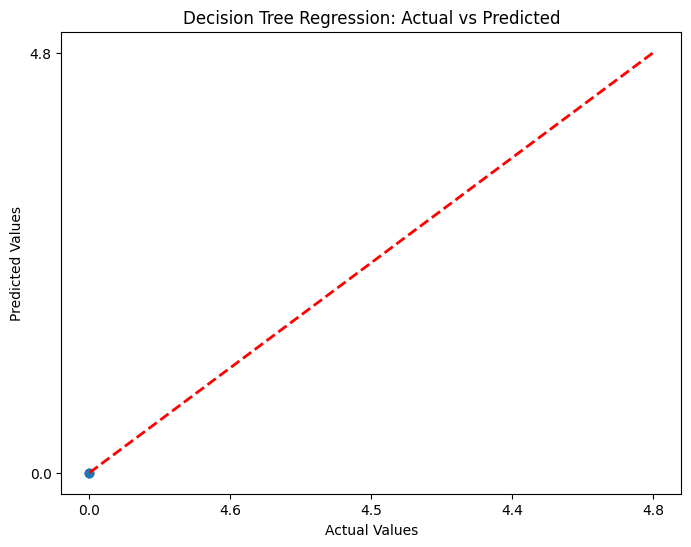

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regression: Actual vs Predicted')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics
mse: 0.06420205686545422
mae: 0.128554862482443
train_score: 0.9946355533716565
test_score: 0.9872161942388287

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the metrics
ax.bar(['Mean Squared Error', 'Mean Absolute Error'], [mse, mae])
ax.set_ylabel('Metric Value')
ax.set_title('Decision Tree Regression Metrics')

# Add the train and test scores
ax.text(0, mse + 0.01, f'Train Score: {train_score:.3f}', ha='center')
ax.text(1, mse + 0.01, f'Test Score: {test_score:.3f}', ha='center')

# Customize the plot
ax.grid(True)
ax.set_ylim(0, max(mse, mae) * 1.2)
plt.show()

SyntaxError: invalid syntax (<ipython-input-58-db9d1fc6e574>, line 3)

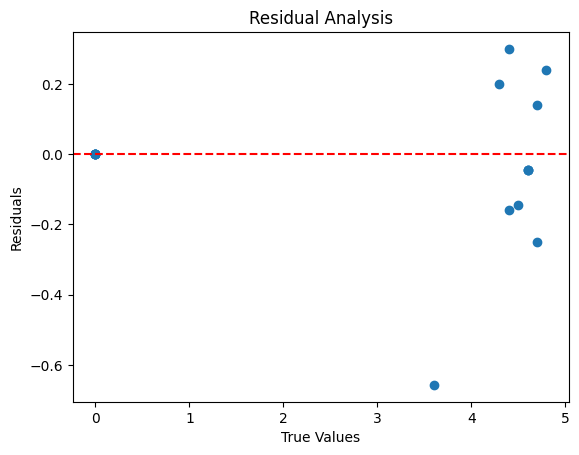

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert y_test and y_pred to numeric types
y_test = pd.to_numeric(y_test)
y_pred = pd.to_numeric(y_pred)

# Perform residual analysis
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


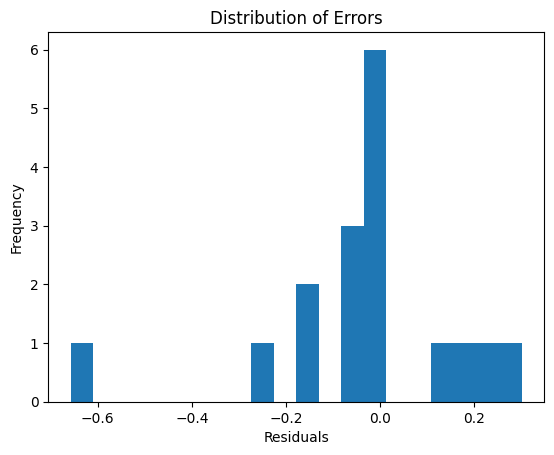

In [ ]:
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.show()

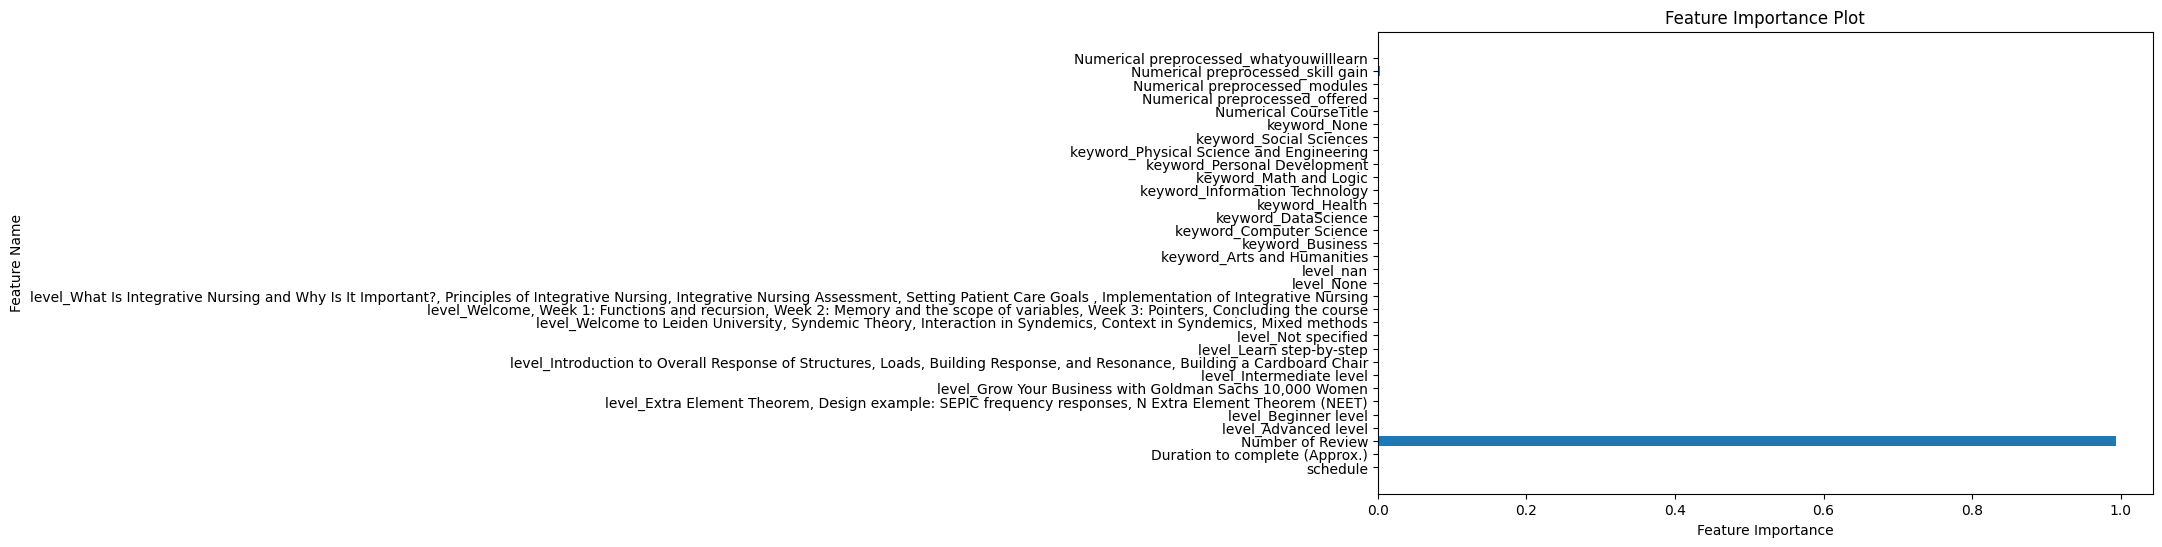

In [ ]:
feature_importances = regressor.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Plot')
plt.show()

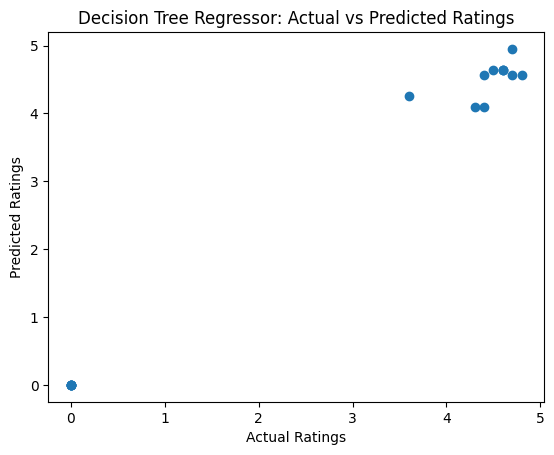

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted ratings
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Decision Tree Regressor: Actual vs Predicted Ratings')
plt.show()

### ***`BEStSVR_RESULT`***

In [143]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target column and all other columns are features
X =df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=50, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

ValueError: could not convert string to float: 'Course5'

In [139]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=50, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, regressor.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(y_test, y_pred)

print("Train Accuracy:", regressor.score(X_train, y_train))
print("Test Accuracy:", regressor.score(X_test, y_test))
print("Train Mean Absolute Error (MAE):", mae_train)
print("Test Mean Absolute Error (MAE):", mae_test)
print("Train Mean Squared Error (MSE):", mse_train)
print("Test Mean Squared Error (MSE):", mse_test)
print("Train R-squared:", r2_train)
print("Test R-squared:", r2_test)

print("Predicted Values:")
print(y_pred[:15])

Train Accuracy: 0.8462909616230379
Test Accuracy: 0.8251749652704246
Train Mean Absolute Error (MAE): 0.44840846828607445
Test Mean Absolute Error (MAE): 0.7018181068327849
Train Mean Squared Error (MSE): 0.7673015491416939
Test Mean Squared Error (MSE): 0.8501094162819115
Train R-squared: 0.8462909616230379
Test R-squared: 0.8251749652704246
Predicted Values:
[ 5.6105456   4.28043211  3.3841267   3.97939491 -0.16749375  2.66635023
  3.57337669  5.07414411  3.4598048   0.10500617 -0.0239447   4.87095277
  0.33772924  0.08835625  5.7827553 ]


In [142]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=50, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Evaluate the model using mean squared error and mean absolute error for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Test Mean Squared Error:", test_mse)
print("Test Mean Absolute Error:", test_mae)
print("Train Mean Squared Error:", train_mse)
print("Train Mean Absolute Error:", train_mae)

# Calculate the R-squared score for train and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using regressor.score (R-squared values)
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Print the first 5 predicted values on the test set
print("First 5 Predicted Values on Test Set:")
print(y_test_pred[:5])

ValueError: could not convert string to float: 'Course5'

In [141]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sample dataframe loading (replace this with your actual dataframe loading)
# df = pd.read_csv('your_dataset.csv')

# Assuming 'df' is your dataframe
# Ensure all necessary preprocessing is done
df = pd.DataFrame({
    'Course Title': ['Course1', 'Course2', 'Course3', 'Course4', 'Course5'],
    'Rating': [4.5, 4.0, 3.5, 4.8, 4.2],
    'Level': ['Beginner', 'Intermediate', 'Advanced', 'Beginner', 'Advanced'],
    'Schedule': ['Flexible', 'Fixed', 'Flexible', 'Flexible', 'Fixed'],
    'What You Will Learn': ['Skill1, Skill2', 'Skill3, Skill4', 'Skill5, Skill6', 'Skill1, Skill4', 'Skill2, Skill5'],
    'Skill Gain': ['Skill1', 'Skill3', 'Skill5', 'Skill1', 'Skill2'],
    'Modules': [10, 15, 8, 20, 12],
    'Instructor': ['Inst1', 'Inst2', 'Inst3', 'Inst1', 'Inst2'],
    'Offered': ['Online', 'Offline', 'Online', 'Online', 'Offline'],
    'Keyword': ['Keyword1', 'Keyword2', 'Keyword3', 'Keyword1', 'Keyword2'],
    'Course Url': ['URL1', 'URL2', 'URL3', 'URL4', 'URL5'],
    'Duration to complete (Approx.)': [10, 15, 8, 20, 12],
    'Number of Review': [100, 150, 80, 200, 120]
})

# Select the feature columns and the target column
X = df.drop(columns=['Rating'])
y = df['Rating']

# Preprocess the data
# OneHotEncode the categorical features, Standardize the numerical features
categorical_features = ['Course Title', 'Level', 'Schedule', 'What You Will Learn', 'Skill Gain', 'Instructor', 'Offered', 'Keyword', 'Course Url']
numerical_features = ['Modules', 'Duration to complete (Approx.)', 'Number of Review']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline that preprocesses the data then applies SVR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=50, gamma='scale'))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Evaluate the model using mean squared error and mean absolute error for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Test Mean Squared Error:", test_mse)
print("Test Mean Absolute Error:", test_mae)
print("Train Mean Squared Error:", train_mse)
print("Train Mean Absolute Error:", train_mae)

# Calculate the R-squared score for train and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using regressor.score (R-squared values)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Print the first 5 predicted values on the test set
print("First 5 Predicted Values on Test Set:")
print(y_test_pred[:5])


ValueError: Found unknown categories ['Course2'] in column 0 during transform

In [ ]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=5, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Evaluate the model using mean squared error and mean absolute error for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Test Mean Squared Error:", test_mse)
print("Test Mean Absolute Error:", test_mae)
print("Train Mean Squared Error:", train_mse)
print("Train Mean Absolute Error:", train_mae)

# Calculate the R-squared score for train and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using regressor.score (R-squared values)
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Print the first 5 predicted values on the test set
print("First 5 Predicted Values on Test Set:")
print(y_test_pred[:5])

Test Mean Squared Error: 0.6634836864640467
Test Mean Absolute Error: 0.5746570316232538
Train Mean Squared Error: 1.508073964054507
Train Mean Absolute Error: 0.6786767485564924
Train R-squared: 0.7034721974618423
Test R-squared: 0.8567343205408626
Training Score: 0.7034721974618423
Testing Score: 0.8567343205408626
First 5 Predicted Values on Test Set:
[0.1000891  4.13074475 3.82925582 3.92946726 3.87452951]


In [ ]:
import numpy as np

# Calculate the Harmonic Regression (HR) score for the test set
test_hr = 1 / np.mean(1 / y_test_pred)
print("Test HR:", test_hr)

Test HR: 0.7758482553247863


In [ ]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=12, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Evaluate the model using mean squared error and mean absolute error for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Test Mean Squared Error:", test_mse)
print("Test Mean Absolute Error:", test_mae)
print("Train Mean Squared Error:", train_mse)
print("Train Mean Absolute Error:", train_mae)

# Calculate the R-squared score for train and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using regressor.score (R-squared values)
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Print the first 5 predicted values on the test set
print("First 5 Predicted Values on Test Set:")
print(y_test_pred[:5])

Test Mean Squared Error: 0.6885517205323043
Test Mean Absolute Error: 0.5825664921255893
Train Mean Squared Error: 1.1293891356560275
Train Mean Absolute Error: 0.5695449137841266
Train R-squared: 0.7779317947336124
Test R-squared: 0.8513213932801584
Training Score: 0.7779317947336124
Testing Score: 0.8513213932801584
First 5 Predicted Values on Test Set:
[0.12284904 4.07897886 3.72816711 3.84989185 4.71164129]


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=50, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)
print("Training Score:", train_score)
print("Testing Score:", test_score)

# Make predictions for new data points
new_data_point = [[5]]  # Replace value_1, value_2, ... with the actual values of features


Mean Squared Error: 0.7454887670275943
R-squared Score: 0.8390270071197141
Training Score: 0.8580984221750974
Testing Score: 0.8390270071197141


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=50, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)
print("Training Score:", train_score)
print("Testing Score:", test_score)

# Print the first 5 predicted values
print("Predicted Values:")
print(y_pred[:5])


Mean Squared Error: 0.7454887670275943
R-squared Score: 0.8390270071197141
Training Score: 0.8580984221750974
Testing Score: 0.8390270071197141
Predicted Values:
[0.23668826 4.20451353 3.93521253 4.11642892 5.90032469]


Mean Squared Error: 0.6715924158211773
Mean Absolute Error: 0.5809018484794749
R-squared Score: 0.854983406924447
Training Score: 0.7666789543896851
Testing Score: 0.854983406924447
Predicted Values:
[0.12207151 4.07233101 3.71780499 3.83549362 4.55064545]


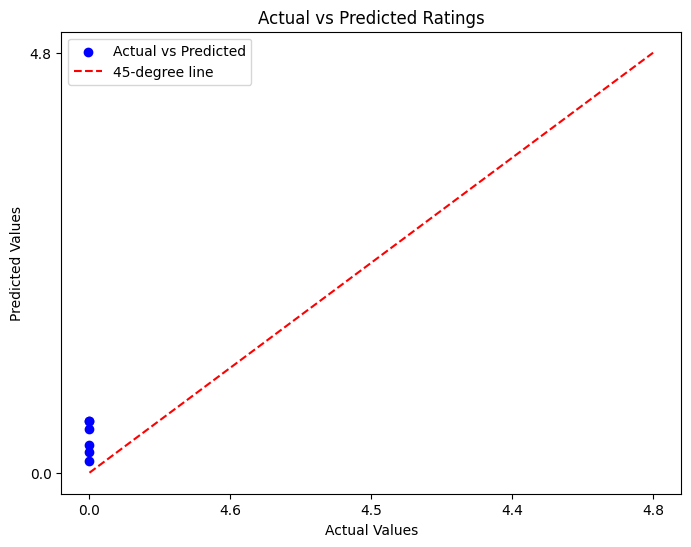

In [ ]:
# Import the necessary libraries
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Rating' is the target column
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=10, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Evaluate the model using mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)
print("Training Score:", train_score)
print("Testing Score:", test_score)

# Print the first 5 predicted values
print("Predicted Values:")
print(y_pred[:5])

# Plotting Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')

# Plotting the 45-degree line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='45-degree line')

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ratings')

# Adding legend
plt.legend()

# Display the plot
plt.show()


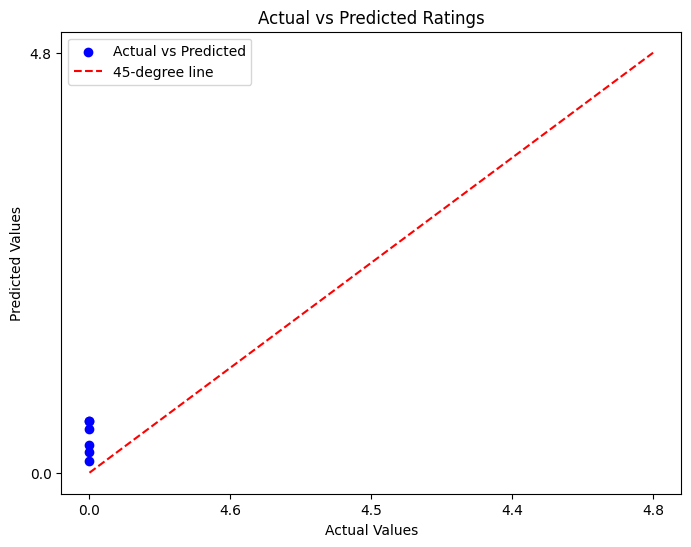

In [ ]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')

# Plotting the 45-degree line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='45-degree line')

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ratings')

# Adding legend
plt.legend()

# Display the plot
plt.show()


### **`*BESTKNEAREST*`**

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=10, metric='manhattan', algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using knn.score (R-squared values)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Train Mean Squared Error: 1.7302090909090906
Test Mean Squared Error: 0.7438529411764706
Train Mean Absolute Error: 0.9984848484848485
Test Mean Absolute Error: 0.6229411764705883
Train R-squared: 0.6597944716985562
Test R-squared: 0.839380230125523
Training Score: 0.6597944716985562
Testing Score: 0.839380230125523


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=5, metric='manhattan', algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using knn.score (R-squared values)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Train Mean Squared Error: 1.3240181818181818
Test Mean Squared Error: 0.5735764705882351
Train Mean Absolute Error: 0.7566666666666666
Test Mean Absolute Error: 0.568235294117647
Train R-squared: 0.739662502414953
Test R-squared: 0.8761479378362224
Training Score: 0.739662502414953
Testing Score: 0.8761479378362224


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=3, metric='manhattan', algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using knn.score (R-squared values)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Train Mean Squared Error: 1.3267171717171717
Test Mean Squared Error: 0.40124183006535946
Train Mean Absolute Error: 0.6449494949494949
Test Mean Absolute Error: 0.3666666666666667
Train R-squared: 0.7391318085876633
Test R-squared: 0.9133600650860065
Training Score: 0.7391318085876633
Testing Score: 0.9133600650860065


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=4, metric='manhattan', algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using knn.score (R-squared values)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Train Mean Squared Error: 1.4392708333333333
Test Mean Squared Error: 0.8096691176470587
Train Mean Absolute Error: 0.7579545454545454
Test Mean Absolute Error: 0.6573529411764705
Train R-squared: 0.7170007389304873
Test R-squared: 0.8251685781530186
Training Score: 0.7170007389304873
Testing Score: 0.8251685781530186


Train Mean Squared Error: 1.3267171717171717
Test Mean Squared Error: 0.40124183006535946
Train Mean Absolute Error: 0.6449494949494949
Test Mean Absolute Error: 0.3666666666666667
Train R-squared: 0.7391318085876633
Test R-squared: 0.9133600650860065


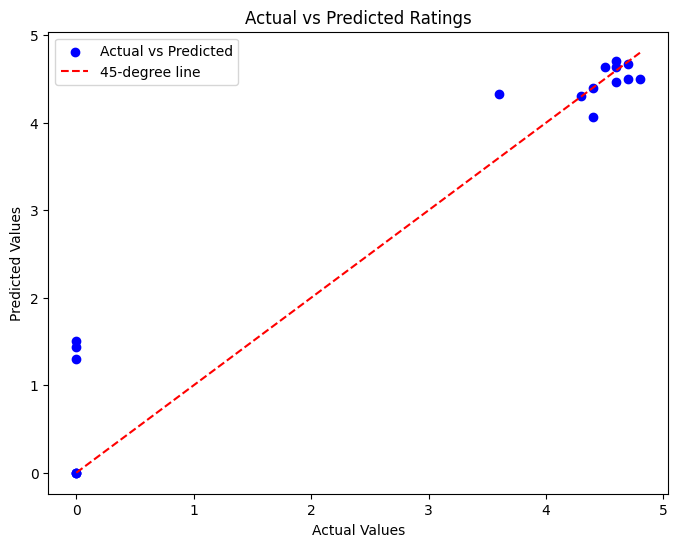

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Rating' is the target column
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure y_train and y_test are of type float
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=3, metric='manhattan', algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Plotting Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')

# Plotting the 45-degree line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='45-degree line')

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ratings')

# Adding legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=25,metric='manhattan',algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using regressor.score (R-squared values)
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)


Train Mean Squared Error: 2.2791585454545453
Test Mean Squared Error: 1.8042183529411764
Train Mean Absolute Error: 1.3778787878787877
Test Mean Absolute Error: 1.2381176470588235
Train R-squared: 0.551856280773724
Test R-squared: 0.610416090854752
Training Score: 0.7666789543896851
Testing Score: 0.854983406924447


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


Train Mean Squared Error: 1.4392708333333333
Test Mean Squared Error: 0.8096691176470587
Train Mean Absolute Error: 0.7579545454545454
Test Mean Absolute Error: 0.6573529411764705
Train R-squared: 0.7170007389304873
Test R-squared: 0.8251685781530186


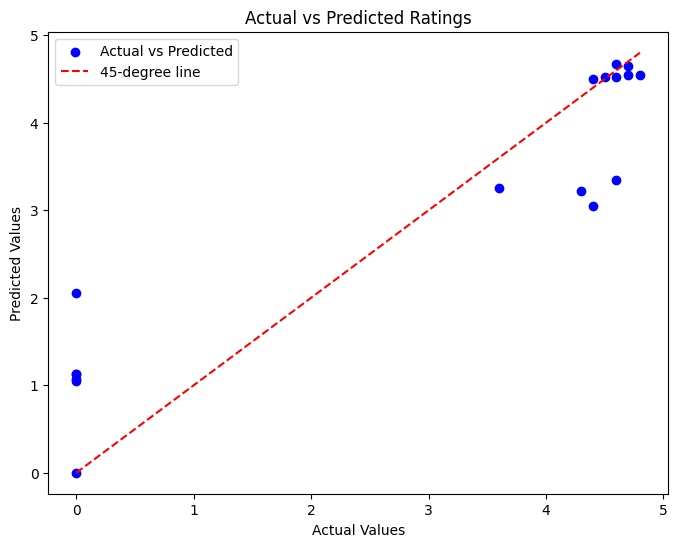

In [ ]:
# Assuming 'df' is your DataFrame and 'Rating' is the target column
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure y_train and y_test are of type float
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=4, metric='manhattan', algorithm='brute')

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Plotting Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')

# Plotting the 45-degree line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='45-degree line')

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ratings')

# Adding legend
plt.legend()

# Display the plot
plt.show()


### ***`BESTRANDOMFOREST`***

In [ ]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Calculate the training and testing scores using regressor.score (R-squared values)
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)


Train Mean Squared Error: 0.009627833333333186
Test Mean Squared Error: 0.037189941176470884
Train Mean Absolute Error: 0.052803030303029616
Test Mean Absolute Error: 0.09370588235294167
Train R-squared: 0.9981069096545759
Test R-squared: 0.9919695957860131
Training Score: 0.7666789543896851
Testing Score: 0.854983406924447


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


Train Mean Squared Error: 0.009627833333333186
Test Mean Squared Error: 0.037189941176470884
Train Mean Absolute Error: 0.052803030303029616
Test Mean Absolute Error: 0.09370588235294167
Train R-squared: 0.9981069096545759
Test R-squared: 0.9919695957860131


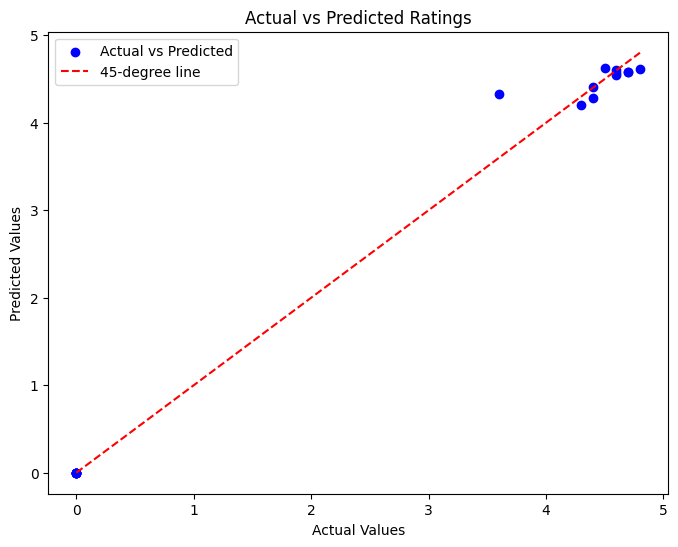

In [ ]:
# Assuming 'df' is your DataFrame and 'Rating' is the target column
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure y_train and y_test are of type float
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Plotting Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')

# Plotting the 45-degree line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='45-degree line')

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ratings')

# Adding legend
plt.legend()

# Display the plot
plt.show()


Train Mean Squared Error: 0.01592203389830507
Test Mean Squared Error: 0.045319999999999985
Train Mean Absolute Error: 0.05694915254237281
Test Mean Absolute Error: 0.15066666666666664
Train R-squared: 0.9966129128853851
Test R-squared: 0.9911499739628536


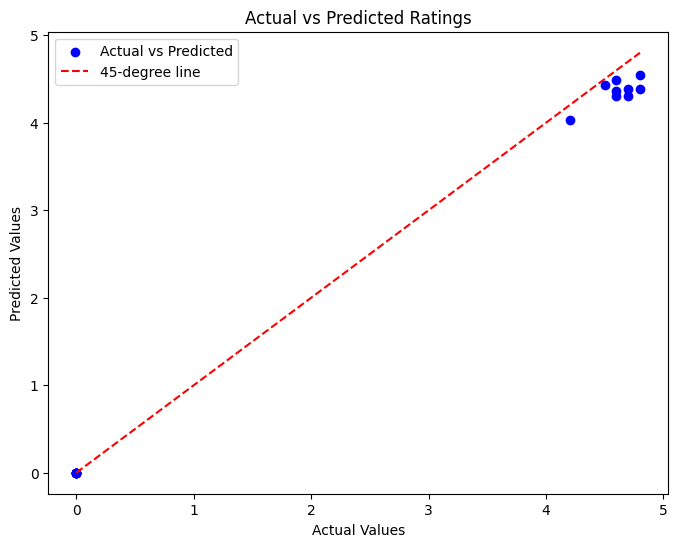

In [ ]:
# Assuming 'df' is your DataFrame and 'Rating' is the target column
X = df.drop(columns=['Rating'])
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure y_train and y_test are of type float
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=10, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

# Plotting Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')

# Plotting the 45-degree line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='45-degree line')

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Ratings')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target column and all other columns are features
X =df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=1000.0, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Mean Squared Error: 3.875988091076721
R-squared Score: 0.24310248178071325
Training Score: 0.9841196348503436
Testing Score: 0.24310248178071325


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target column and all other columns are features
X =df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel
regressor = SVR(kernel='rbf', C=50, gamma='scale')  # Adjust C and gamma as needed
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

Mean Squared Error: 1.7279730874275572
R-squared Score: 0.6625638390286406
Training Score: 0.9170972833941339
Testing Score: 0.6625638390286406


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel and increased C, decreased gamma
regressor = SVR(kernel='rbf', C=60, gamma=0.1)
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Cross-Validation Mean Score:", cv_scores.mean())

Mean Squared Error: 5.749015111109919
R-squared Score: -0.12265960770676254
Training Score: 0.9978711425644182
Testing Score: -0.12265960770676254
Cross-Validation Scores: [-0.12847952  0.036363   -0.02991656 -0.11099625 -0.0658726 ]
Cross-Validation Mean Score: -0.05978038585696752


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target column and all other columns are features
X = df.loc[:, df.columns != 'Rating']
y = df['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and fit the SVR model with the RBF kernel and increased C, decreased gamma
regressor = SVR(kernel='rbf', C=5, gamma=0.5)
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2_score = regressor.score(X_test, y_test)
print("R-squared Score:", r2_score)

# Calculate the training and testing scores
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Cross-Validation Mean Score:", cv_scores.mean())

Mean Squared Error: 5.924981087149288
R-squared Score: -0.1570219967094164
Training Score: 0.9978741235542047
Testing Score: -0.1570219967094164
Cross-Validation Scores: [-0.14045663  0.00117489 -0.03605188 -0.09819961 -0.1161701 ]
Cross-Validation Mean Score: -0.07794066479869213


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=9)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error and mean absolute error
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)

Train Mean Squared Error: 1.785239589872358
Test Mean Squared Error: 0.9779999999999999
Train Mean Absolute Error: 1.0097928436911485
Test Mean Absolute Error: 0.5755555555555554


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=9)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Accuracy:", knn.score(X_train, y_train))
print("Test Accuracy:", knn.score(X_test, y_test))
print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Mean Absolute Error (MAE):", train_mae)
print("Test Mean Absolute Error (MAE):", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

print("Predicted Values:")
print(y_test_pred[:5])

Train Accuracy: 0.6202267844687457
Test Accuracy: 0.8090175316785281
Train Mean Squared Error (MSE): 1.785239589872358
Test Mean Squared Error (MSE): 0.9779999999999999
Train Mean Absolute Error (MAE): 1.0097928436911485
Test Mean Absolute Error (MAE): 0.5755555555555554
Train R-squared: 0.6202267844687457
Test R-squared: 0.8090175316785281
Predicted Values:
[4.44444444 4.44444444 4.53333333 4.46666667 0.82222222]


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=10)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Accuracy:", knn.score(X_train, y_train))
print("Test Accuracy:", knn.score(X_test, y_test))
print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Mean Absolute Error (MAE):", train_mae)
print("Test Mean Absolute Error (MAE):", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

print("Predicted Values:")
print(y_test_pred[:5])

Train Accuracy: 0.6271802853912671
Test Accuracy: 0.8423385696927617
Train Mean Squared Error (MSE): 1.7525525423728814
Test Mean Squared Error (MSE): 0.8073666666666668
Train Mean Absolute Error (MAE): 1.013220338983051
Test Mean Absolute Error (MAE): 0.5579999999999999
Train R-squared: 0.6271802853912671
Test R-squared: 0.8423385696927617
Predicted Values:
[4.48 4.44 4.52 4.43 1.17]


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=4)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Accuracy:", knn.score(X_train, y_train))
print("Test Accuracy:", knn.score(X_test, y_test))
print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Mean Absolute Error (MAE):", train_mae)
print("Test Mean Absolute Error (MAE):", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

print("Predicted Values:")
print(y_test_pred[:5])

Train Accuracy: 0.7682599993888838
Test Accuracy: 0.7178224266620379
Train Mean Squared Error (MSE): 1.0893644067796608
Test Mean Squared Error (MSE): 1.4449999999999998
Train Mean Absolute Error (MAE): 0.5855932203389831
Test Mean Absolute Error (MAE): 0.5899999999999997
Train R-squared: 0.7682599993888838
Test R-squared: 0.7178224266620379
Predicted Values:
[4.5   4.375 4.525 4.55  0.   ]


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model
knn = KNeighborsRegressor(n_neighbors=6)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Accuracy:", knn.score(X_train, y_train))
print("Test Accuracy:", knn.score(X_test, y_test))
print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Mean Absolute Error (MAE):", train_mae)
print("Test Mean Absolute Error (MAE):", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

print("Predicted Values:")
print(y_test_pred[:5])

Train Accuracy: 0.7249949752667691
Test Accuracy: 0.8105580628363132
Train Mean Squared Error (MSE): 1.2927448210922787
Test Mean Squared Error (MSE): 0.9701111111111111
Train Mean Absolute Error (MAE): 0.7511299435028248
Test Mean Absolute Error (MAE): 0.48888888888888876
Train R-squared: 0.7249949752667691
Test R-squared: 0.8105580628363132
Predicted Values:
[4.45       4.45       4.51666667 4.53333333 0.66666667]


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=15)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

Train Mean Squared Error: 1.9382048964218457
Test Mean Squared Error: 0.9464651851851854
Train Mean Absolute Error: 1.1564971751412427
Test Mean Absolute Error: 0.7280000000000001
Train R-squared: 0.5876865435607024
Test R-squared: 0.8151756060869062


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=40)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

Train Mean Squared Error: 3.586211652542373
Test Mean Squared Error: 4.032123333333335
Train Mean Absolute Error: 1.7975423728813558
Test Mean Absolute Error: 1.942
Train R-squared: 0.23710680707061438
Test R-squared: 0.21261261065787174


In [ ]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert y_train and y_test to numerical data types
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create the K-Nearest Neighbors regressor model with more neighbors
knn = KNeighborsRegressor(n_neighbors=2)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Evaluate the model using mean squared error, mean absolute error, and R-squared
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train Mean Squared Error:", train_mse)
print("Test Mean Squared Error:", test_mse)
print("Train Mean Absolute Error:", train_mae)
print("Test Mean Absolute Error:", test_mae)
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

Train Mean Squared Error: 0.6784322033898305
Test Mean Squared Error: 1.5615
Train Mean Absolute Error: 0.3754237288135593
Test Mean Absolute Error: 0.5566666666666666
Train R-squared: 0.8556774223118526
Test R-squared: 0.6950724700572817
